# Analysis of tsPC algorithm direct vs intermediate learning

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
import os
from pathlib import Path
from pprint import pprint
import json
import collections
from itertools import combinations, chain
import scipy.stats

import numpy as np
import bnlearn as bn
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from numpy.random import Generator, PCG64
import pingouin as pg

from dodiscover.ci.simulate import nonlinear_additive_gaussian
from dodiscover.ci import Oracle
from dodiscover.constraint.timeseries import TimeSeriesPC
from dodiscover.constraint import FCI
from dodiscover.constraint.timeseries.utils import convert_ts_df_to_multiindex
from dodiscover.context_builder import make_ts_context, make_context

from pywhy_graphs.classes.timeseries.functions import get_summary_graph
from pywhy_graphs.simulate import simulate_linear_var_process
from pywhy_graphs import acyclification
from pywhy_graphs.viz import draw
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
n_vars = 10
p_time_self = 0.0
p_time_vars = 0.1
p_contemporaneous = 0.0
max_lag = 5
n_realizations = 2
n_times = 1000
random_state = 12345

In [43]:
data, var_model = simulate_linear_var_process(
    n_variables=n_vars,
    p_time_self=p_time_self,
    p_time_vars=p_time_vars,
    p_contemporaneous=p_contemporaneous,
    max_lag=max_lag,
    n_times=n_times,
    n_realizations=n_realizations,
    random_state=random_state,
)

In [45]:
summary_graph = get_summary_graph(var_model, include_self_loops=False)

# convert the summary graph to a MixedEdgeGraph to allow acyclification
summary_me_graph = nx.MixedEdgeGraph(graphs=[summary_graph], edge_types=["directed"])

acyc_summary_graph = acyclification(summary_me_graph)

In [46]:
print(summary_graph.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [47]:
# now run analysis
summary_oracle = Oracle(acyc_summary_graph)
summary_alg = FCI(ci_estimator=summary_oracle)
context = make_context().variables(summary_graph.nodes).build()
summary_alg.fit(data.copy(), context)

summary_pag = summary_alg.graph_

In [48]:
print(summary_alg.n_ci_tests)

46080


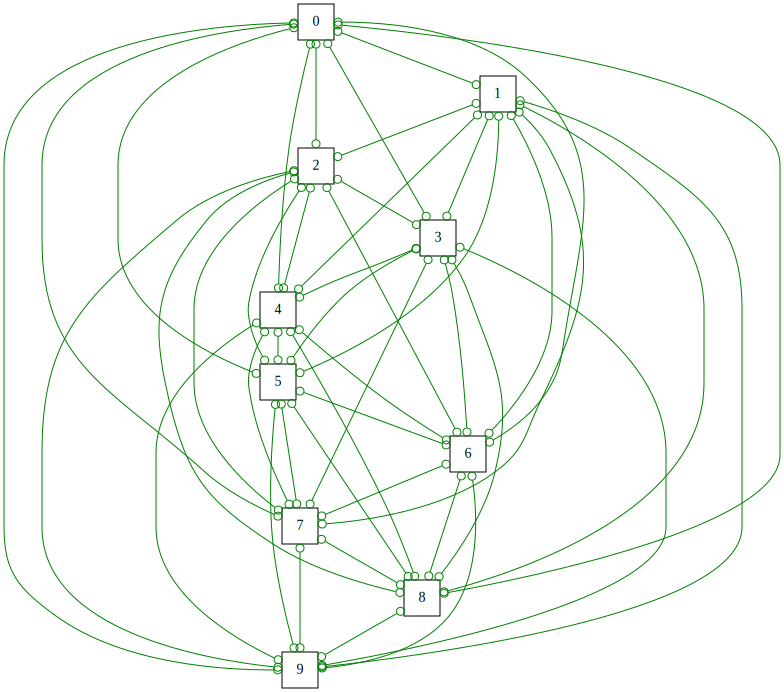

In [38]:
draw(summary_pag)

In [49]:
print(data.head())

          0         1         2         3         4         5         6  \
0 -0.071271  0.688282  0.007146 -0.815815 -0.571033 -0.110419 -0.359480   
1  0.474050 -1.154530  0.534360  0.386579  0.000786  0.467919 -0.748644   
2 -0.414854  0.650452 -1.065808 -0.223639 -1.063643  0.890607 -0.965479   
3  0.097717 -1.388360 -0.181473 -0.701691  1.301715  1.023009  0.360035   
4 -1.640418 -0.907382  1.621952 -1.795713  0.747873  0.312383 -0.244553   

          7         8         9  
0 -0.155248  0.201999  0.392494  
1  1.063831 -0.428074  0.781443  
2 -0.275172  1.848289  1.453272  
3 -1.853336  1.899953  0.820186  
4 -0.124342 -0.098425  0.087705  


In [59]:
# create an oracle
oracle = Oracle(var_model)
ts_alg = TimeSeriesPC(ci_estimator=oracle, separate_lag_phase=False, contemporaneous_edges=False)
context = make_ts_context().max_lag(max_lag).variables(data=data).build()
# now test the full fit algorithm
ts_alg.fit(data.copy(), context)
ts_pag = alg.graph_

Testing nodes in the following order for learning skeleton: [(3, -5), (5, -5), (6, -5), (1, -5), (9, -5), (4, -5), (0, -5), (7, -5), (2, -5), (8, -5), (6, -4), (1, -4), (9, -4), (4, -4), (0, -4), (7, -4), (2, -4), (8, -4), (3, -4), (5, -4), (0, -3), (9, -3), (4, -3), (7, -3), (2, -3), (8, -3), (3, -3), (5, -3), (6, -3), (1, -3), (7, -2), (2, -2), (8, -2), (3, -2), (5, -2), (6, -2), (1, -2), (9, -2), (4, -2), (0, -2), (7, -1), (2, -1), (8, -1), (3, -1), (5, -1), (6, -1), (1, -1), (9, -1), (4, -1), (0, -1), (9, 0), (4, 0), (0, 0), (7, 0), (2, 0), (8, 0), (3, 0), (5, 0), (6, 0), (1, 0)]
Testing (3, -5) against possible adjacencies [(4, 0), (3, -2), (3, -1), (4, -3), (5, -5), (5, -2), (5, -1), (8, -3), (9, -4), (8, 0), (0, -4), (1, -3), (2, -4), (1, 0), (7, -5), (7, -2), (6, -4), (7, -1), (3, -3), (4, -4), (3, 0), (5, -3), (9, -5), (5, 0), (9, -2), (0, -5), (8, -4), (9, -1), (0, -1), (0, -2), (2, -5), (2, -2), (1, -4), (2, -1), (7, -3), (6, -5), (7, 0), (6, -2), (6, -1), (4, -5), (4, -2), 

RuntimeError: From lag 4 should be larger than to lag 5.

In [ ]:
print(ts_alg.n_ci_tests)

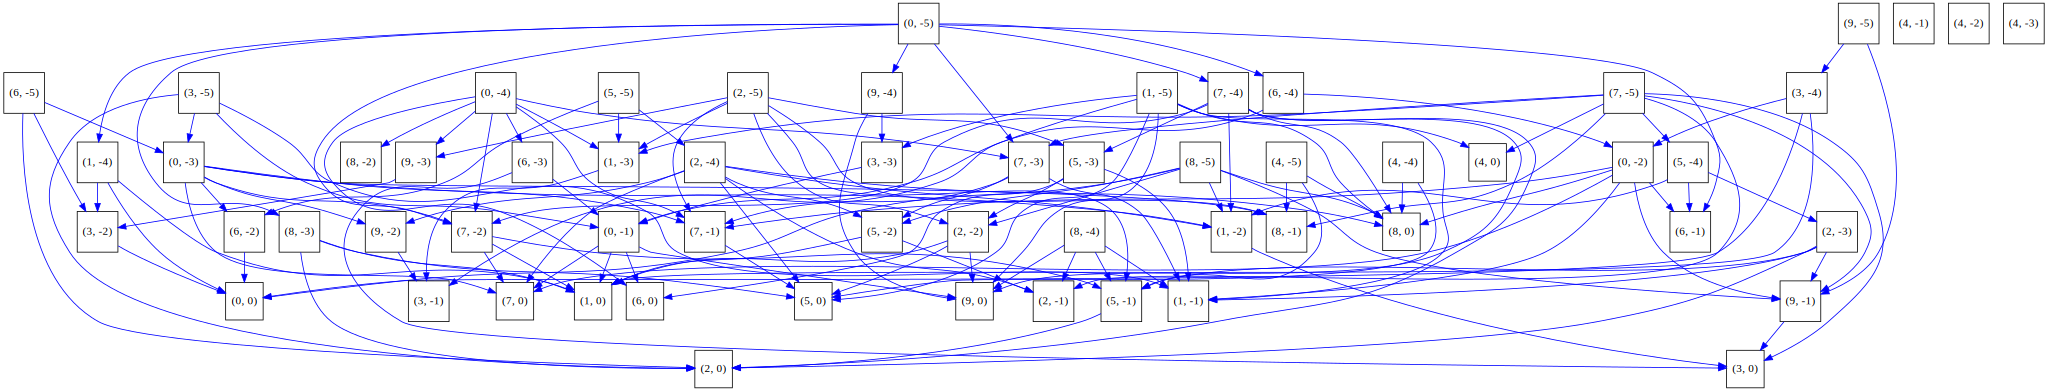

In [57]:
draw(var_model)